In [1]:
import pandas
import matplotlib as mpl
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import geopy.distance

def cal_dist(ds):
    lons = ds.lon.values
    lats = ds.lat.values
    ilen_lats = len(lats)
    dx=[0]*len(lats)
    dy=[0]*len(lats)
    dx_grid = np.empty([len(lats),len(lons)])    
    dy_grid = np.empty([len(lats),len(lons)])    
    for j in range(0,len(lats)):
        i=10 #just a random lon
        coords_1 = (lats[j], lons[i-1])  #cpr sample location
        coords_2 = (lats[j], lons[i])  #eddy location
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m   
        for i in range(1,len(lons)-1):
            dx[j]=arclen_temp
    for j in range(1,len(lats)):
        i=10 #just a random lon
        coords_1 = (lats[j], lons[i])  #cpr sample location
        coords_2 = (lats[j-1], lons[i])  #eddy location
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m       
        dy[j]=arclen_temp
    j=0
    i=10 #just a random lon
    coords_1 = (lats[j], lons[i])  #cpr sample location
    coords_2 = (lats[j+1], lons[i])  #eddy location
    arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m       
    dy[j]=arclen_temp
    for i in range(0,len(lons)):
        for j in range(0,len(lats)):
            dx_grid[j,i]=dx[j]
            dy_grid[j,i]=dy[j]
    datax = xr.DataArray(dx_grid, coords={'lat': ds.lat,'lon':ds.lon}, dims=('lat', 'lon'))
    datay = xr.DataArray(dy_grid, coords={'lat': ds.lat,'lon':ds.lon}, dims=('lat', 'lon'))
    ds['dx_grid']=datax
    ds['dy_grid']=datay
    return ds


def wrf_vort( U, V, dx,dy ):
    """Calculate the relative vorticity given the U and V vector components in m/s
    and the grid spacing dx in meters.
    U and V must be the same shape.
    ---------------------
    U (numpy.ndarray): ndarray of U vector values in m/s
    V (numpy.ndarray): ndarray of V vector values in m/s
    dx (float or int): float or integer of U and V grispacing in meters
    ---------------------
    returns:
        numpy.ndarray of vorticity values s^-1 same shape as U and V
    """
#    assert U.shape == V.shape, 'Arrays are different shapes. They must be the same shape.'
    
    du = np.gradient( U )
    dv = np.gradient( V )
    return ( dv[-1]/dx - du[-2]/dy )

dir_data='F:/data/sat_data/ccmp/v02.0/'
def get_ccmp_filename_daily(lyr,idyjl):
    dir_data='F:/data/sat_data/ccmp/v02.0/'
    d = dt.date(lyr,1,1) + dt.timedelta(idyjl - 1)
    syr, smon, sdym =str(d.year).zfill(4), str(d.month).zfill(2), str(d.day).zfill(2)
    filename = dir_data + 'Y' + syr + '/M' + smon + '/CCMP_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    if lyr>=2018:
        filename = dir_data + 'Y' + syr + '/M' + smon + '/CCMP_RT_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    return filename
def get_ccmp_filename_month_new(lyr):
    dir_data='F:/data/sat_data/ccmp/v02.0/monthly/'
    syr, smon =str(lyr).zfill(4), str(imon).zfill(2)
    filename = dir_data + 'CCMP_Wind_Analysis_' + syr + '_V02.0_L3.0_RSS.nc'
    return filename

In [2]:
lyr=2000
filename = get_ccmp_filename_daily(2000,1)
ds = xr.open_dataset(filename,drop_variables='nobs')
ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
ds = ds.rename({'longitude':'lon','latitude':'lat'})
print(ds)
ds.close()

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, time: 4)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T18:00:00
Data variables:
    uwnd     (time, lat, lon) float32 2.101699 2.131792 ... -9.585934 -9.500353
    vwnd     (time, lat, lon) float32 -2.6582468 -2.64885 ... 10.275465
    spd      (time, lat, lon) float32 3.3887188 3.4001389 ... 13.994352
    dir      (time, lat, lon) float32 -51.668915 -51.17292 ... 132.75545
Attributes:
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP V2.0 derived surface winds (Level 3.0)
    history:                    20160212T034001ZZ - netCDF generated from ori...
    description:                RSS VAM 6-hour analyses starting 

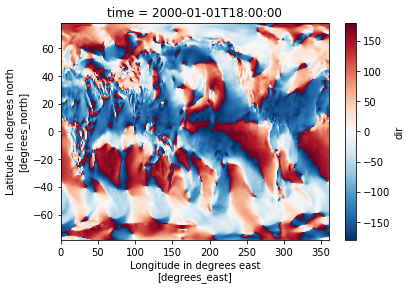

In [16]:
ds.dir[3,:,:].plot()

In [2]:
from os.path import exists
import os
#make cmc monthly average ssts
#start from daily ratehr than use RSS monthly averages since want spd and dir not averaged
for lyr in range(1988,2019):
    ds_mnth=[]
    for imon in range(1,13):
        init = 0
        for idyjl in range(1,366):
            d = dt.date(lyr,1,1) + dt.timedelta(idyjl - 1)
            if d.month!=imon:
                continue
            filename = get_ccmp_filename_daily(lyr,idyjl)
            if not os.path.exists(filename):  
                continue
            print(filename)
            ds = xr.open_dataset(filename,drop_variables='nobs')
            ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
            ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
            ds = ds.rename({'longitude':'lon','latitude':'lat'})
            ds.close()
#now calculate relative vorticity
            ds= cal_dist(ds)
            dvort = []
            init_vort = 0
            for i in range(0,4):
                dvort = wrf_vort( ds.uwnd[i,:,:], ds.vwnd[i,:,:], ds.dx_grid,ds.dy_grid)
                if init_vort==0:
                    ds_vort = dvort
                    init_vort = 1
                else:
                    ds_vort = xr.concat([ds_vort,dvort],dim = 'time')
            ds['rel_vorticity']=ds_vort
            if init==0:
                ds_sum = ds
                init = 1
            else:
                ds_sum = xr.concat([ds_sum,ds],dim = 'time')
            #print(idyjl,ds_sum.dims)
        ds_clim2 = ds_sum.resample(time='M').mean()    
        ds_clim2['spd']=(ds_clim2.uwnd**2+ds_clim2.vwnd**2)**.5
        ds_clim2['dir']=np.arctan2(ds_clim2.vwnd,ds_clim2.uwnd)* 180./pi
        ds_mnth.append(ds_clim2)
    combined = xr.concat(ds_mnth, dim='time')
    filename = get_ccmp_filename_month_new(lyr)
    combined.to_netcdf(filename)
    

F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M01/CCMP_Wind_Analysis_20080112_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080408_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080409_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080410_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080411_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080413_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080414_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080416_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080417_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M04/CCMP_Wind_Analysis_20080419_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080715_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080720_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080721_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080722_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080723_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080724_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M07/CCMP_Wind_Analysis_20080726_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081026_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081027_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M10/CCMP_Wind_Analysis_20081031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2008/M11/CCMP_Wind_Analysis_20081101_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2009/M01/CCMP_Wind_Analysis_20090128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M01/CCMP_Wind_Analysis_20090129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M01/CCMP_Wind_Analysis_20090130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M01/CCMP_Wind_Analysis_20090131_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M02/CCMP_Wind_Analysis_20090208_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090506_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090507_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090508_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090509_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090510_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090511_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090512_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090513_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090514_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090515_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090516_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M05/CCMP_Wind_Analysis_20090517_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090819_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090820_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090821_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090822_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M08/CCMP_Wind_Analysis_20090823_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2009/M11/CCMP_Wind_Analysis_20091129_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2010/M02/CCMP_Wind_Analysis_20100224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M02/CCMP_Wind_Analysis_20100225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M02/CCMP_Wind_Analysis_20100226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M02/CCMP_Wind_Analysis_20100227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M02/CCMP_Wind_Analysis_20100228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100302_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100304_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M03/CCMP_Wind_Analysis_20100307_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100603_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100604_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100605_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100606_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100607_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100608_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100609_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100610_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100611_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100612_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M06/CCMP_Wind_Analysis_20100613_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M09/CCMP_Wind_Analysis_20100919_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2010/M12/CCMP_Wind_Analysis_20101226_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110328_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110329_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M03/CCMP_Wind_Analysis_20110331_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M04/CCMP_Wind_Analysis_20110401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M04/CCMP_Wind_Analysis_20110402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M04/CCMP_Wind_Analysis_20110403_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2011/M06/CCMP_Wind_Analysis_20110629_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M06/CCMP_Wind_Analysis_20110630_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110701_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110702_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110703_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110704_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110705_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110706_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110707_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110708_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110709_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M07/CCMP_Wind_Analysis_20110710_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2011/M10/CCMP_Wind_Analysis_20111016_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120113_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M01/CCMP_Wind_Analysis_20120122_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120419_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120420_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120421_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120423_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120424_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120425_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120426_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120427_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120428_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M04/CCMP_Wind_Analysis_20120429_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120726_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120727_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120728_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120729_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120730_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M07/CCMP_Wind_Analysis_20120731_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M08/CCMP_Wind_Analysis_20120801_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M08/CCMP_Wind_Analysis_20120802_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M08/CCMP_Wind_Analysis_20120803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M08/CCMP_Wind_Analysis_20120804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M08/CCMP_Wind_Analysis_20120805_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2012/M10/CCMP_Wind_Analysis_20121031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2012/M11/CCMP_Wind_Analysis_20121111_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M02/CCMP_Wind_Analysis_20130218_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130516_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130517_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130518_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130519_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130520_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130521_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130522_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130523_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130524_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130525_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130526_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M05/CCMP_Wind_Analysis_20130527_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130822_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130823_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130824_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M08/CCMP_Wind_Analysis_20130831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M09/CCMP_Wind_Analysis_20130901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M09/CCMP_Wind_Analysis_20130902_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2013/M11/CCMP_Wind_Analysis_20131128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M11/CCMP_Wind_Analysis_20131129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M11/CCMP_Wind_Analysis_20131130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2013/M12/CCMP_Wind_Analysis_20131209_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140309_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140310_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140311_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140312_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140313_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140314_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140315_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M03/CCMP_Wind_Analysis_20140317_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140612_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140613_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140614_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140615_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140616_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140617_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140618_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M06/CCMP_Wind_Analysis_20140623_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140919_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140920_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M09/CCMP_Wind_Analysis_20140929_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2014/M12/CCMP_Wind_Analysis_20141231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M01/CCMP_Wind_Analysis_20150101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M01/CCMP_Wind_Analysis_20150102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M01/CCMP_Wind_Analysis_20150103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M01/CCMP_Wind_Analysis_20150104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M01/CCMP_Wind_Analysis_20150105_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150403_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150404_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150405_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150406_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150407_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150408_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150409_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150410_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150411_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M04/CCMP_Wind_Analysis_20150413_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150709_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150710_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150711_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150713_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150714_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150715_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M07/CCMP_Wind_Analysis_20150720_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151016_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151017_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2015/M10/CCMP_Wind_Analysis_20151026_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M01/CCMP_Wind_Analysis_20160131_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M02/CCMP_Wind_Analysis_20160201_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2016/M04/CCMP_Wind_Analysis_20160428_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M04/CCMP_Wind_Analysis_20160429_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M04/CCMP_Wind_Analysis_20160430_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160501_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160502_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160503_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160504_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160505_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160506_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160507_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160508_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M05/CCMP_Wind_Analysis_20160509_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M08/CCMP_Wind_Analysis_20160815_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161113_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2016/M11/CCMP_Wind_Analysis_20161121_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M02/CCMP_Wind_Analysis_20170228_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2017/M05/CCMP_Wind_Analysis_20170526_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M05/CCMP_Wind_Analysis_20170527_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M05/CCMP_Wind_Analysis_20170528_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M05/CCMP_Wind_Analysis_20170529_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M05/CCMP_Wind_Analysis_20170530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M05/CCMP_Wind_Analysis_20170531_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M06/CCMP_Wind_Analysis_20170601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M06/CCMP_Wind_Analysis_20170602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M06/CCMP_Wind_Analysis_20170603_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M06/CCMP_Wind_Analysis_20170604_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M06/CCMP_Wind_Analysis_20170605_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M06/CCMP_Wind_Analysis_20170606_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M09/CCMP_Wind_Analysis_20170912_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2017/M12/CCMP_Wind_Analysis_20171219_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180315_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180317_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180318_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180319_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_RT_Wind_Analysis_20180325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M03/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180618_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180623_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180624_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180625_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180626_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180627_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_RT_Wind_Analysis_20180628_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M06/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M09/CCMP_RT_Wind_Analysis_20180930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M10/CCMP_RT_Wind_Analysis_20181001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M10/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/Y2018/M12/CCMP_RT_Wind_Analysis_20181231_V02.0_L3.0_RSS.nc


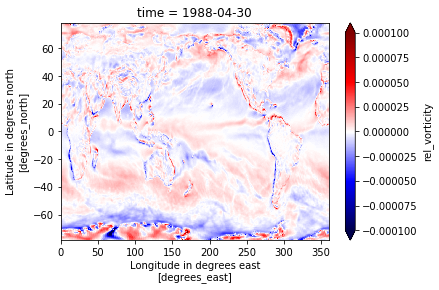

In [10]:
combined.rel_vorticity[3,:,:].plot(vmin=-.0001,vmax=.0001,cmap='seismic')

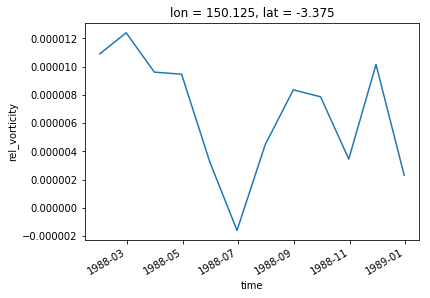

In [11]:
combined.rel_vorticity[:,300,600].plot()

combined

In [4]:
#make cmc climatology from monthly files
dir_data='F:/data/sat_data/ccmp/v02.0/monthly/'
for icase in range(0,3):
    if icase==0:
        iyr1,iyr2 = 1988,2000
    if icase==1:
        iyr1,iyr2 = 2000,2010
    if icase==2:
        iyr1,iyr2 = 2010,2019
    init = 0
    for lyr in range(iyr1,iyr2): 
        filename = get_ccmp_filename_month_new(lyr)
        ds = xr.open_dataset(filename)
        if init==0:
            ds_sum = ds
            init = 1
        else:
            ds_sum = xr.concat([ds_sum,ds],dim = 'time')
        print(lyr,ds_sum.dims)
    ds_sum2 = ds_sum.groupby('time.month').mean('time')
    fname_tem=dir_data + 'climatology_'+str(iyr1)+'_'+str(iyr2-1)+'_CCMP_Wind_Analysis_L3.0.nc'
    ds_sum2.to_netcdf(fname_tem)


1988 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 12}))
1989 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 24}))
1990 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 36}))
1991 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 48}))
1992 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 60}))
1993 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 72}))
1994 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 84}))
1995 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 96}))
1996 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 108}))
1997 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 120}))
1998 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 132}))
1999 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 144}))
2000 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 12}))
2001 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 24}))
2002 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time

In [8]:
dir_data='F:/data/sat_data/ccmp/v02.0/monthly/'
num_year = 2018-1988+1
num_year_file1 = 1999 - 1988 +1
num_year_file2 = 2009 - 2000 +1 
num_year_file3 = 2018 - 2010 +1
frac_file1 = num_year_file1 / num_year
frac_file2 = num_year_file2 / num_year
frac_file3 = num_year_file3 / num_year
fname_tem=dir_data + 'climatology_1988_1999_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds = xr.open_dataset(fname_tem)
ds_masked = ds #ds.where(ds['mask'] == 1.) 
ds.close()
fname_tem=dir_data + 'climatology_2000_2009_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds = xr.open_dataset(fname_tem)
ds_masked2 = ds #ds.where(ds['mask'] == 1.) 
#ds_sum = xr.concat([ds_masked2,ds_masked],dim = 'time')
ds.close()
fname_tem=dir_data + 'climatology_2010_2018_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds = xr.open_dataset(fname_tem)
ds_masked3 = ds #ds.where(ds['mask'] == 1.) 
#ds_sum = xr.concat([ds_masked2,ds_masked],dim = 'time')
ds.close()
ds_ave = frac_file1*ds_masked + frac_file2*ds_masked2 + frac_file3*ds_masked3
#ds_sum = ds_sum.mean('time',skipna=True)
print(frac_file1+frac_file2+frac_file3,frac_file1,frac_file2,frac_file3)
fname_tem=dir_data + 'climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc'
print(fname_tem)
ds_ave.to_netcdf(fname_tem)

F:/data/sat_data/ccmp/v02.0/monthly/climatology_1988_1999_CCMP_Wind_Analysis_L3.0.nc
F:/data/sat_data/ccmp/v02.0/monthly/climatology_2000_2009_CCMP_Wind_Analysis_L3.0.nc
F:/data/sat_data/ccmp/v02.0/monthly/climatology_2010_2018_CCMP_Wind_Analysis_L3.0.nc
1.0 0.3870967741935484 0.3225806451612903 0.2903225806451613
F:/data/sat_data/ccmp/v02.0/monthly/climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc


In [10]:
ds_sum2

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, month: 12)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd     (month, lat, lon) float32 0.08409567 0.100546025 ... -1.2747644
    vwnd     (month, lat, lon) float32 -4.1172147 -4.152534 ... -3.2976847
    spd      (month, lat, lon) float32 4.419509 4.4540963 ... 8.421315 8.486904
    dir      (month, lat, lon) float32 -88.65275 -88.37244 ... -46.316708

In [9]:
#make cmc climatology from monthly files
init = 0
for lyr in range(2000,2018): #2017):
    fname_tem=str(lyr) + 'monthly_average_ccmp_V02.0_L3.5_RSS.nc'
    cmc_filename_out = dir_data + fname_tem
    ds = xr.open_dataset(cmc_filename_out)
    #ds.rename({'longitude':'lon','latitude':'lat'}, inplace = True)
    if init==0:
        ds_sum = ds
        init = 1
    else:
        ds_sum = xr.concat([ds_sum,ds],dim = 'time')
    print(lyr,ds_sum.dims)
ds_sum2 = ds_sum.groupby('time.month').mean('time')
#ds_sum = ds_sum.mean('time',skipna=True)
fname_tem='2000_2017_monthly_climatology_ccmp_V02.0_L3.5_RSS.nc'
cmc_filename_out = dir_data + fname_tem
ds_sum2.to_netcdf(cmc_filename_out)
 

2000 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 12}))
2001 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 24}))
2002 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 36}))
2003 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 48}))
2004 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 60}))
2005 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 72}))
2006 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 84}))
2007 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 96}))
2008 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 108}))
2009 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 120}))
2010 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 132}))
2011 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 144}))
2012 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 156}))
2013 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'time': 168}))
2014 Frozen(SortedKeysDict({'lon': 1440, 'lat': 628, 'ti

In [ ]:
#change climatology lat lon from altitude longitude
fname_tem='monthly_climatology_ccmp_V02.0_L3.5_RSS.nc'
cmc_filename_out = dir_data + fname_tem
fname_tem='monthly_climatology_ccmp_V02.0_L3.5_RSSa.nc'
cmc_filename_outa = dir_data + fname_tem
ds = xr.open_dataset(cmc_filename_out)
ds.rename({'longitude':'lon','latitude':'lat'}, inplace = True)
ds.to_netcdf(cmc_filename_outa)
ds.close()



In [ ]:
ds

In [ ]:
#OLD CODE
#make ccmp monthly average ssts in annual file
for lyr in range(1988,2018): #2017):
    ds_mnth=[]
    for imon in range(1,13):
        filename = dir_data + 'Y' + str(lyr) + '/M' + str(imon).zfill(2) + '/CCMP_Wind_Analysis_' + str(lyr) + str(imon).zfill(2) + '_V02.0_L3.5_RSS.nc'
        ds = xr.open_dataset(filename)
        ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
        ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
        ds = ds.rename({'longitude':'lon','latitude':'lat'})
        ds_mnth.append(ds)
        ds.close()
    combined = xr.concat(ds_mnth, dim='time')
    fname_tem= str(lyr) + 'monthly_average_ccmp_V02.0_L3.5_RSS.nc'
    cmc_filename_out = dir_data + fname_tem
    combined.to_netcdf(cmc_filename_out)